In [85]:
# Plot the best matches of a template event

In [86]:
## Import modules
from matplotlib import pyplot as plt
from matplotlib import ticker
from obspy import read, UTCDateTime, Stream
from cc_utils import read_template_and_match, read_and_process_template_waveforms, read_and_process_match_waveforms
from snuffler_utils import read_normal_markers
from preproc_utils import preprocess_stream
from os.path import join
from numpy import abs, amax, amin, arange
import pandas as pd

In [87]:
## Inputs
root = "/Volumes/OmanData/geophones_no_prefilt/data"
timewin = "2020-01-12-17-00-00"
tempname = "Sibling2"
station = "A05"

freqmin = 10.0
freqmax = None
dur = 0.04
mincc = 0.7
numdet_min = 4

numplots = 10
begin = -0.05
end = 0.15

In [88]:
## Read the template and match file
if freqmax is None:
    suffix = f"Highpass{freqmin:.0f}Hz_Dur{dur:.2f}s_MinCC{mincc:.1f}_MinDet{numdet_min:d}"
else:
    suffix  = f"Bandpass{freqmin:.0f}-{freqmax:.0f}Hz_Dur{dur:.2f}s_MinCC{mincc:.1f}_MinDet{numdet_min:d}"

filename = f"CCmatches_{tempname}_{suffix}.dat"

inpath = join(root, timewin, filename)
tempmatch = read_template_and_match(inpath)
template = tempmatch.template
matches = tempmatch.matches

In [89]:
## Sort the matches by average CC
matches = sorted(matches, key=lambda x: x.average_cc, reverse=True)


In [90]:
## Read and process the template event
tempwaveforms = read_and_process_template_waveforms(template, root, freqmin, freqmax, stations=[station], begin=begin, end=end)

In [91]:
### Read and process the match events
list_of_matchwaves = []
nummat = len(matches)
numplots = amin([numplots, nummat])
for i in range(numplots):
    match = matches[i]
    matchwaveforms = read_and_process_match_waveforms(match, root, freqmin, freqmax, stations=[station], begin=begin, end=end)
    list_of_matchwaves.append(matchwaveforms)

Text(0.5, 1.0, 'Sibling2, A05')

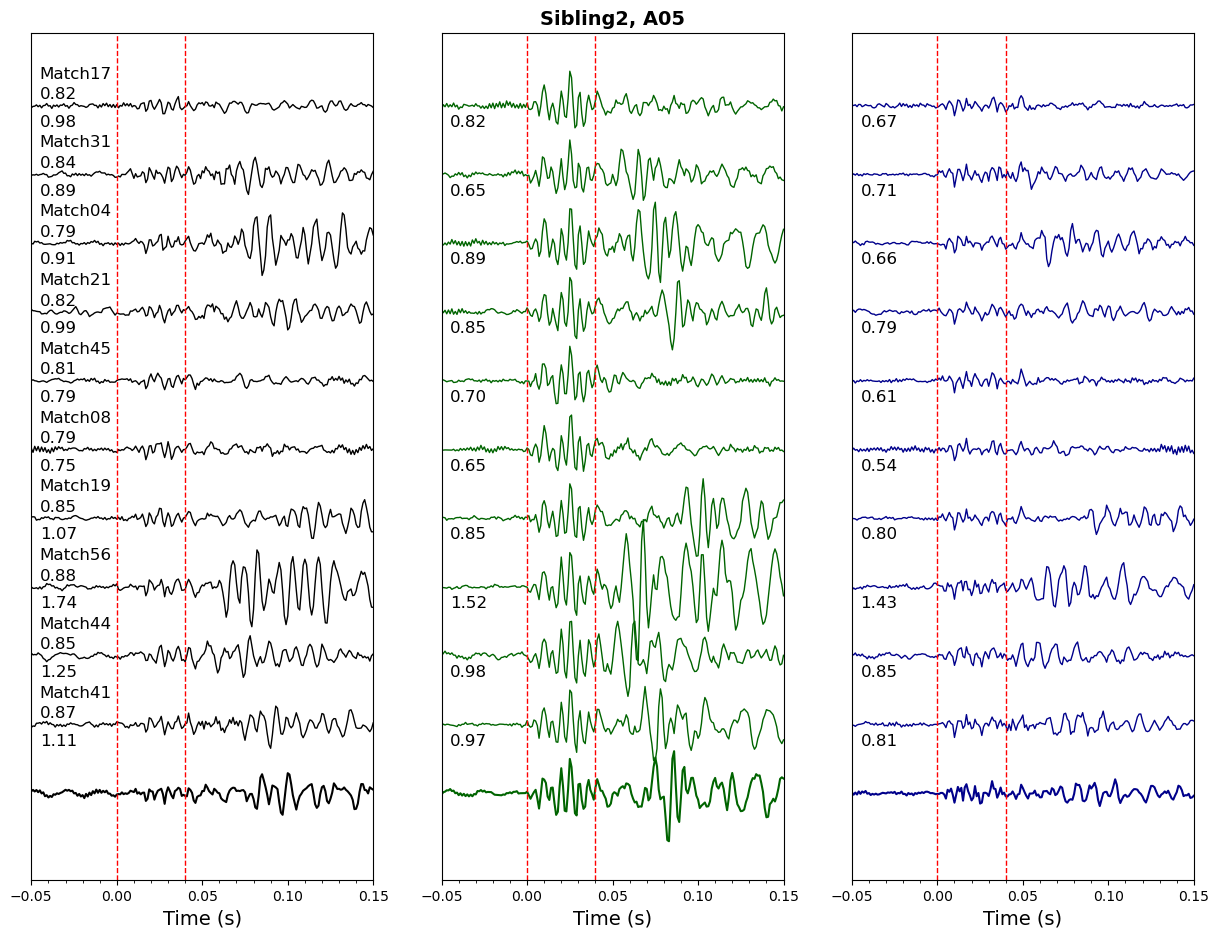

In [92]:
### Plot the waveforms
scale = 0.5

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, numplots+1))

#### Plot the template
starttime = UTCDateTime(template.get_start_time_for_station(station))

tempstr = tempwaveforms.waveforms
temptra_z = tempstr.select(channel="*Z")[0]
temptra_1 = tempstr.select(channel="*1")[0]
temptra_2 = tempstr.select(channel="*2")[0]

temptra_win_z = temptra_z.slice(starttime=starttime, endtime=starttime+dur)
temptra_win_1 = temptra_1.slice(starttime=starttime, endtime=starttime+dur)
temptra_win_2 = temptra_2.slice(starttime=starttime, endtime=starttime+dur)

data_z = temptra_z.data
data_1 = temptra_1.data
data_2 = temptra_2.data

data_win_z = temptra_win_z.data
data_win_1 = temptra_win_1.data
data_win_2 = temptra_win_2.data

amp = amax([amax(abs(data_win_z)), amax(abs(data_win_1)), amax(abs(data_win_2))])
data_z = data_z / amp * scale
data_1 = data_1 / amp * scale
data_2 = data_2 / amp * scale

timeax = temptra_z.times()+begin

axes[0].plot(timeax, data_z, color="black", linewidth=1.5)
axes[1].plot(timeax, data_1, color="darkgreen", linewidth=1.5)
axes[2].plot(timeax, data_2, color="darkblue", linewidth=1.5)

#### Plot the matches

for i in range(numplots):
    matchwaveforms = list_of_matchwaves[i]
    matchname = matchwaveforms.match_info.name
    starttime = UTCDateTime(matchwaveforms.match_info.get_info_for_station(station)["start_time"])

    if matchwaveforms.active_stations == []:
        continue

    matchtra_z = matchwaveforms.waveforms.select(channel="*Z")[0]
    matchtra_1 = matchwaveforms.waveforms.select(channel="*1")[0]
    matchtra_2 = matchwaveforms.waveforms.select(channel="*2")[0]

    matchtra_win_z = matchtra_z.slice(starttime=starttime, endtime=starttime+dur)
    matchtra_win_1 = matchtra_1.slice(starttime=starttime, endtime=starttime+dur)
    matchtra_win_2 = matchtra_2.slice(starttime=starttime, endtime=starttime+dur)

    data_z = matchtra_z.data
    data_1 = matchtra_1.data
    data_2 = matchtra_2.data

    data_win_z = matchtra_win_z.data
    data_win_1 = matchtra_win_1.data
    data_win_2 = matchtra_win_2.data

    amp = amax([amax(abs(data_win_z)), amax(abs(data_win_1)), amax(abs(data_win_2))])
    data_z = data_z / amp * scale + i + 1
    data_1 = data_1 / amp * scale + i + 1
    data_2 = data_2 / amp * scale + i + 1

    timeax = matchtra_z.times()+begin

    axes[0].plot(timeax, data_z, color="black", linewidth=1)
    axes[1].plot(timeax, data_1, color="darkgreen", linewidth=1)
    axes[2].plot(timeax, data_2, color="darkblue", linewidth=1)

    ccinfo = matchwaveforms.match_info.get_info_for_station(station)
    ccval = ccinfo["cc_value"]
    amprat_z = ccinfo["amplitude_ratio_z"]
    amprat_1 = ccinfo["amplitude_ratio_1"]
    amprat_2 = ccinfo["amplitude_ratio_2"]

    axes[0].annotate(matchname, xy=(begin+0.005, i+1+0.4), xycoords="data", fontsize=12, clip_on=False)
    axes[0].annotate(f"{ccval:.2f}", xy=(begin+0.005, i+1+0.1), xycoords="data", fontsize=12)
    axes[0].annotate(f"{amprat_z:.2f}", xy=(begin+0.005, i+1-0.3), xycoords="data", fontsize=12)
    axes[1].annotate(f"{amprat_1:.2f}", xy=(begin+0.005, i+1-0.3), xycoords="data", fontsize=12)
    axes[2].annotate(f"{amprat_2:.2f}", xy=(begin+0.005, i+1-0.3), xycoords="data", fontsize=12)

#### Plot the markers
axes[0].axvline(0, color="red", linestyle="--", linewidth=1)
axes[0].axvline(dur, color="red", linestyle="--", linewidth=1)

axes[1].axvline(0, color="red", linestyle="--", linewidth=1)
axes[1].axvline(dur, color="red", linestyle="--", linewidth=1)

axes[2].axvline(0, color="red", linestyle="--", linewidth=1)
axes[2].axvline(dur, color="red", linestyle="--", linewidth=1)
    
#### Set the axes
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[2].set_yticks([])

axes[0].set_xlim(begin, end)
axes[1].set_xlim(begin, end)
axes[2].set_xlim(begin, end)

axes[0].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
axes[2].xaxis.set_major_locator(ticker.MultipleLocator(0.05))

axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
axes[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
axes[2].xaxis.set_minor_locator(ticker.MultipleLocator(0.01))

axes[0].set_xlabel("Time (s)", fontsize=14)
axes[1].set_xlabel("Time (s)", fontsize=14)
axes[2].set_xlabel("Time (s)", fontsize=14)

axes[1].set_title(f"{tempname}, {station}", fontsize=14, fontweight="bold")

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

axes[0].set_xlim(begin, end)
axes[1].set_xlim(begin, end)
axes[2].set_xlim(begin, end)

axes[0].set_xlabel("Time (s)", fontsize=14)
axes[1].set_xlabel("Time (s)", fontsize=14)
axes[2].set_xlabel("Time (s)", fontsize=14)

axes[1].set_title(f"{tempname}, {station}", fontsize=14, fontweight="bold")
    

In [93]:
### Save the figure
fig.tight_layout()

filename = f"BestMatches_{tempname}_{suffix}.png"
outpath = join(root, timewin, filename)
fig.savefig(outpath, dpi=300, transparent=True)

In [94]:
print(template.stations)

['A04', 'A05', 'A03', 'A02', 'A06', 'A01']
